# Spam Model using Keras
## Imports

In [1]:
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

2022-09-26 11:49:22.756897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-26 11:49:23.682758: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-26 11:49:25.265522: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/marcel/libtorch/lib:
2022-09-26 11:49:25.265770: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: can

## Import dataset and normalize

In [2]:
# Read data
data = pd.read_csv('./input/MatrixData', sep='\t')


def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split()
    clean_words = [word for word in words if (
        word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(clean_words)

# Remve unknown
data.dropna(inplace=True)

# Convert label to something useful
def change_labels(x): return 1 if x == "spam" else 0
data['label'] = data['label'].apply(change_labels)  

# Count by label
spam = 0
ham = 0


def count_labels(x):
    if x == 1:
        global spam
        spam += 1
    else:
        global ham
        ham += 1
    return x
#.apply(count_labels)
#print("Spam: ", spam)
#print("Ham: ", ham)

# Remove stopwords
data['message'] = data['message'].apply(
    remove_stopwords)

# Print unbalanced
print(data.groupby('label').describe().T)


#ham_msg = data[data.label == 0]
#spam_msg = data[data.label == 1]

#randomly taking data from ham_msg
#ham_msg = ham_msg.sample(n=len(spam_msg)*2, random_state=42)

#data = pd.concat([ham_msg, spam_msg]).reset_index(drop=True)

# Balanced
print(data.groupby('label').describe().T)

# Shuffle data
data = data.sample(frac=1).reset_index(drop=True)

# Split data into messages and label sets
sentences = data['message'].tolist()
labels = data['label'].tolist()

# Separate out the sentences and labels into training and test sets
#training_size = int(len(sentences) * 0.8)
training_size = int(len(sentences) * 0.7)
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

label                                0  \
message count                     4845   
        unique                    4533   
        top     Sorry, I'll call later   
        freq                        30   

label                                                           1  
message count                                                 750  
        unique                                                644  
        top     Please call customer service representative FR...  
        freq                                                    4  
label                                0  \
message count                     4845   
        unique                    4533   
        top     Sorry, I'll call later   
        freq                        30   

label                                                           1  
message count                                                 750  
        unique                                                644  
        top     Please call custom

## Tokenize

In [3]:
vocab_size = 1000
embedding_dim = 16
#embedding_dim = 32
#max_length = 120
max_length = None
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"


In [4]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type,
                       truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                               padding=padding_type, truncating=trunc_type)


## Model

In [5]:
from datetime import datetime

from tensorflow import keras

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

hypermodel_logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_hypermodel"
hypermodel_tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=hypermodel_logdir)

hypertuner_logdir = "hypertuner_logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
hypertuner_tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=hypertuner_logdir)
# Define the checkpoint directory to store the checkpoints.
checkpoint_dir = './training_checkpoints'
# Define the name of the checkpoint files.
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

#es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [6]:
def model_builder(hp):
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 6-512
    hp_units = hp.Int('units', min_value=6, max_value=512, step=12)
    hp_dropout = hp.Float('dropout', min_value=.1, max_value=.9, step=.01)
    hp_l2 = hp.Float('l2', min_value=0.0001, max_value=0.001, step=0.0001)
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dropout(hp_dropout,),
        tf.keras.layers.Dense(units=hp_units, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(hp_l2)),
        #tf.keras.layers.Dense(6, activation='relu',
        #                      kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(hp_dropout,),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Adam was best so far
    # tf.keras.optimizers.Nadam() has similar results to Adam but a bit worse. second best
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5,])
    opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    # opt = tf.keras.optimizers.Nadam()
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=opt, metrics=['accuracy'])
    #print(model.summary())

    return model


## Get best hypermodel values

In [7]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=750,
                     factor=3,
                     directory='hyper_tuning',
                     project_name='spam-keras')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(padded, training_labels_final, epochs=800, verbose=0,
             validation_data=(testing_padded, testing_labels_final), callbacks=[hypertuner_tensorboard_callback, stop_early])
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
The optimal dropout rate is {best_hps.get('dropout')} and the optimal l2 rate is {best_hps.get('l2')}.
""")

INFO:tensorflow:Reloading Oracle from existing project hyper_tuning/spam-keras/oracle.json


2022-09-26 11:49:32.695952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


INFO:tensorflow:Reloading Tuner from hyper_tuning/spam-keras/tuner0.json


2022-09-26 11:49:32.820214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-26 11:49:32.820285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-26 11:49:32.822176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-26 11:49:32.822979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built witho

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 330 and the optimal learning rate for the optimizer is 0.01.
The optimal dropout rate is 0.5499999999999998 and the optimal l2 rate is 0.0001.



### Train

In [8]:
num_epochs = 200
model = tuner.hypermodel.build(best_hps)
history = model.fit(padded, 
                    training_labels_final, 
                    epochs=num_epochs, 
                    verbose=0, 
                    callbacks=[tensorboard_callback,],
                    validation_data=(testing_padded, testing_labels_final))


val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
print("Average train loss: ", np.average(history.history['loss']))
print("Average test loss: ", np.average(history.history['val_loss']))

hypermodel = tuner.hypermodel.build(best_hps)
hypermodel_history = hypermodel.fit(padded, training_labels_final, verbose=0,
               epochs=best_epoch, validation_split=0.2,
                                    callbacks=[hypermodel_tensorboard_callback,
                                                tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                                                    save_weights_only=True),
                                                                                    #es_callback
                                                ],
               )

print("Average train loss(hypermodel_history): ",
      np.average(hypermodel_history.history['loss']))
print("Average test loss(hypermodel_history): ",
      np.average(hypermodel_history.history['val_loss']))


Best epoch: 6
Average train loss:  0.006002985829836689
Average test loss:  0.22046395140389602
Average train loss(hypermodel_history):  0.10212815863390763
Average test loss(hypermodel_history):  0.08288264522949855


INFO:tensorflow:Assets written to: ./models/spam_keras_1664186466.3541195/assets


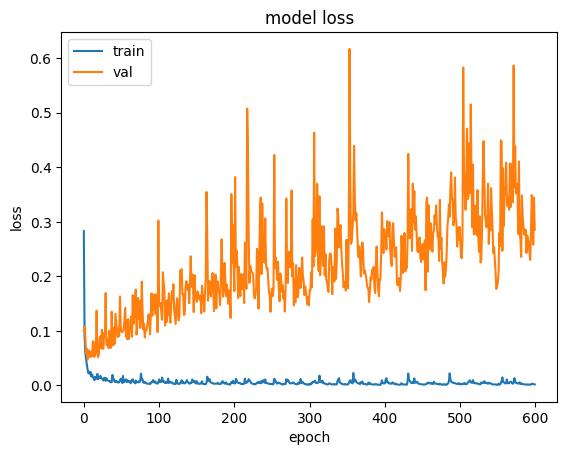

In [9]:
# Save model
import time

hypermodel.save(f"./models/spam_keras_{time.time()}")

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

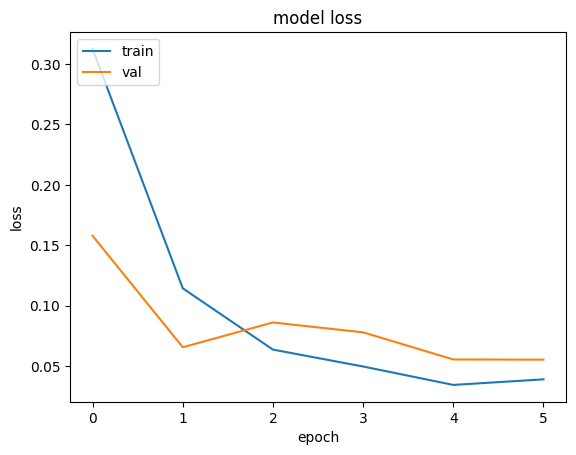

In [10]:
# summarize history for accuracy
plt.plot(hypermodel_history.history['loss'])
plt.plot(hypermodel_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [11]:
# Use the model to predict whether a message is spam
text_messages = ['Greg, can you call me back once you get this?',
                 'Congrats on your new iPhone! Click here to claim your prize...',
                 'Really like that new photo of you',
                 'Did you hear the news today? Terrible what has happened...',
                 'Attend this free COVID webinar today: Book your session now...',
                 'Are you coming to the party tonight?',
                 'Your parcel has gone missing',
                 'Do not forget to bring friends!',
                 'You have won a million dollars! Fill out your bank details here...',
                 'Looking forward to seeing you again',
                 'oh wow https://github.com/MGCodesandStats/tensorflow-nlp/blob/master/spam%20detection%20tensorflow%20v2.ipynb works really good on spam detection. Guess I go with that as the base model then lol :D',
                 'ayo',
                 'Almost all my spam is coming to my non-gmail address actually',
                 'Oh neat I think I found the sizing sweetspot for my data :D',
                 'would never click on buttons in gmail :D always expecting there to be a bug in gmail that allows js to grab your google credentials :D XSS via email lol. I am too scared for touching spam in gmail',
                 'back to cacophony ',
                 'Room version 11 when',
                 'skip 11 and go straight to 12',
                 '100 events should clear out any events that might be causing a request to fail lol']

#print(text_messages)

# Create the sequences
padding_type = 'post'
sample_sequences = tokenizer.texts_to_sequences(text_messages)
fakes_padded = pad_sequences(
    sample_sequences, padding=padding_type, maxlen=max_length)

classes = hypermodel.predict(fakes_padded)

# The closer the class is to 1, the more likely that the message is spam
for x in range(len(text_messages)):
  print(f"Message: \"{text_messages[x]}\"")
  print(f"Likeliness of spam in percentage: {classes[x][0]}")
  print('\n')


1/1 [==============================] - 0s 73ms/step
Message: "Greg, can you call me back once you get this?"
Likeliness of spam in percentage: 0.7976732850074768


Message: "Congrats on your new iPhone! Click here to claim your prize..."
Likeliness of spam in percentage: 0.9998524188995361


Message: "Really like that new photo of you"
Likeliness of spam in percentage: 0.008655842393636703


Message: "Did you hear the news today? Terrible what has happened..."
Likeliness of spam in percentage: 0.0016309074126183987


Message: "Attend this free COVID webinar today: Book your session now..."
Likeliness of spam in percentage: 0.9975067973136902


Message: "Are you coming to the party tonight?"
Likeliness of spam in percentage: 0.00012246571714058518


Message: "Your parcel has gone missing"
Likeliness of spam in percentage: 0.0040820869617164135


Message: "Do not forget to bring friends!"
Likeliness of spam in percentage: 0.013192469254136086


Message: "You have won a million dollars! F

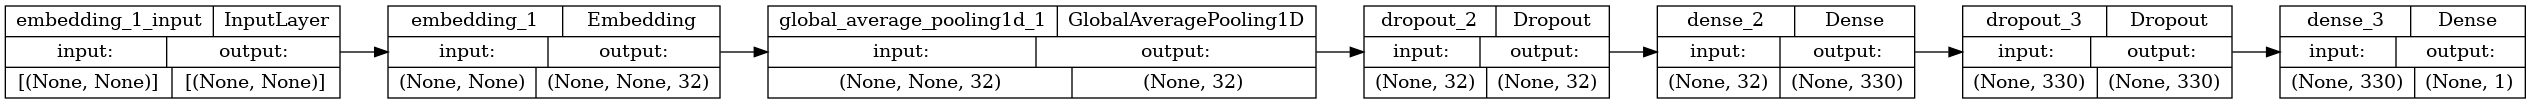

In [12]:
tf.keras.utils.plot_model(model, rankdir="LR", show_shapes=True)
